# Differential Privacy and QIF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
    from qif import *
except: # install qif if not available (for running in colab, etc)
    import IPython; IPython.get_ipython().run_line_magic('pip', 'install qif')
    from qif import *

In [2]:
def get_pi(a, n):
    return [a] + [(1-a) / (n-1) for i in range(n-1)]

print(get_pi(1/5, 5))

[0.2, 0.2, 0.2, 0.2, 0.2]


In [3]:
def get_C(n, m, b):
    return np.array([get_pi(b, m)] + [get_pi(1/m, m) for i in range(n-1)])

print(get_C(5, 3, 0.5))

[[0.5        0.25       0.25      ]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


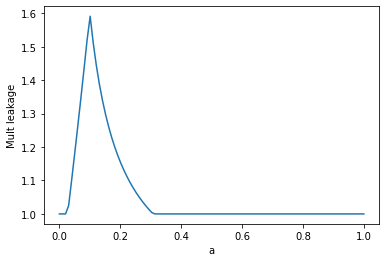

In [45]:
n = 10
m = 5
b = 0.8

aa = np.linspace(0, 1, 100)
plt.plot(aa, [measure.bayes_vuln.mult_leakage(get_pi(a, n), get_C(n, m, b)) for a in aa])
plt.xlabel('a')
plt.ylabel('Mult leakage')
None

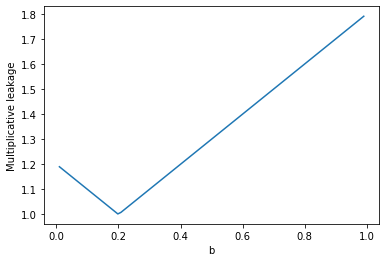

In [41]:
n = 10
m = 5
a = 1/n

bb = np.linspace(0+1/100, 1-1/100, 100)
plt.plot(bb, [measure.bayes_vuln.mult_leakage(get_pi(a, n), get_C(n, m, b)) for b in bb])
plt.xlabel('b')
plt.ylabel('Multiplicative leakage')
None

In [6]:
def get_min_epsilon(m, a, b):
    if (m == 0) or (m-1 == 0) or (b == 0) or (1-b == 0):
        return 0
    return max(np.log(1/(m*b)), np.log(m*b), np.log((m-1)/(m*(1-b))), np.log(m*(1-b)/(m-1)))

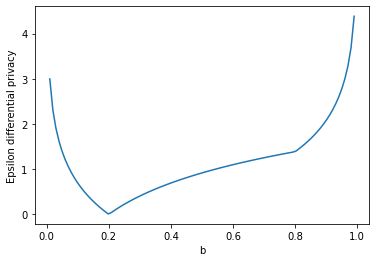

In [42]:
n = 10
m = 5
a = 1/n

bb = np.linspace(0+1/100, 1-1/100, 100)
plt.plot(bb, [get_min_epsilon(m, a, b) for b in bb])
plt.xlabel('b')
plt.ylabel('Epsilon differential privacy')
None

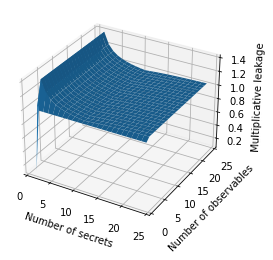

In [32]:
# Set up a figure twice as tall as it is wide
fig = plt.figure(figsize=plt.figaspect(2.))
ax = fig.add_subplot(1, 1, 1, projection='3d')

b = 0.09

n = 25
X = np.arange(1, n)
Y = np.arange(1, n)
X, Y = np.meshgrid(X, Y)
#Z = [[measure.bayes_vuln.mult_leakage(get_pi(1/X[i][j], X[i][j]), get_C(X[i][j], Y[i][j], b)) for i in range(n-1)] for j in range(n-1)]
Z = [[measure.bayes_vuln.mult_leakage(get_pi(1/X[i][j], X[i][j]), get_C(X[i][j], Y[i][j], b)) for i in range(n-1)] for j in range(n-1)]
Z = np.array(Z)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                       linewidth=0)
ax.set_xlabel('Number of secrets')
ax.set_ylabel('Number of observables')
ax.set_zlabel('Multiplicative leakage')
plt.show()
None

[1 2 3 4]
[1 2 3 4]
[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]
[[1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]]
[[2 3 4 5]
 [3 4 5 6]
 [4 5 6 7]
 [5 6 7 8]]


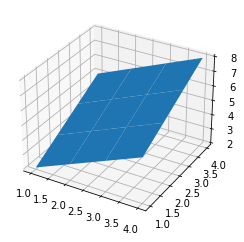

In [21]:
X = np.arange(1, 5)
Y = np.arange(1, 5)
print(X)
print(Y)
X, Y = np.meshgrid(X, Y)
print(X)
print(Y)
Z = np.array([[X[i][j] + Y[i][j] for i in range(4)] for j in range(4)])
print(Z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
None

In [11]:
C = np.array([
    [3/4, 1/6, 1/18, 1/36],
    [1/4, 1/2, 1/6, 1/12],
    [1/12, 1/6, 1/2, 1/4],
    [1/36, 1/18, 1/6, 3/4],
])

pi = probab.uniform(4)
print(pi)
print(channel.hyper(C, pi)[1])

[0.25 0.25 0.25 0.25]
[[0.675  0.1875 0.0625 0.025 ]
 [0.225  0.5625 0.1875 0.075 ]
 [0.075  0.1875 0.5625 0.225 ]
 [0.025  0.0625 0.1875 0.675 ]]


Statistical databases store the data of a large number of individuals, and data analysts are allowed to pose statistical queries about those data. Typical queries include average values, total counting, or the percentage of the entries that satisfy a given property. In principle we would like to consider aggregate information as public, and specific information about any individual as private. 

However, since the two kinds of information are intrinsically linked, it is not easy to make available the former without revealing the latter. Consider, for example, a database that stores the values of the salaries of a set of individuals, and consider the general queries “What is the average salary of the people in the database?” and “How many people are in the database?”. Both queries are about aggregate information, but by posing them immediately before and after the addition of a new individual to the database, the data analyst can infer exactly the salary of that individual.

**Dferential privacy** ensures that the presence or absence of any individual in a database, or changing the data of any individual, does not significantly affect the probability of obtaining any specific answer for a certain query.

It can can be seen as having essentially the same goal as quantitative information flow, namely to control the leakage of sensitive information. In this notebook, we are going to try to explore similarities and differences bewteen the two approaches.

### Definition

Let $X$ be the set of all possible databases. Two databases $x$, $x′$ in $X$ are adjacent (or neighbors), written $x∼x′$, if they differ in the presence of, or in the value associated with, exactly one individual. A mechanism is a probabilistic function $K$ from $X$ to some set of possible answers $Z$.

>_We say that a mechanism $K$ from $X$ to $Z$ satisfies $\epsilon$-differential privacy for some $\epsilon \geq 0$, if for all pairs $x, x' \in X$ with $x∼x'$, and all $z \in Z$ we have_
>
>$$
P\left[ K(x) = z\right] \leq e^{\epsilon} \cdot P \left[K(x') = z\right] 
$$
>
>_where $P(\cdot)$ denotes the probability symbol._